<a href="https://colab.research.google.com/github/Apple03244/Colaboratory/blob/main/wide%26deep_tpye2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import google.colab as colab
f=colab.files
File=f.upload()

Saving train.csv to train.csv


In [112]:
import pandas as pd
data=pd.read_csv('/content/train.csv')

In [113]:
data["일시"]=data["일시"].apply(lambda x:pd.to_datetime(x))

In [114]:
data.head(3)

,일시,최고기온,최저기온,일교차,강수량,평균습도,평균풍속,일조합,일사합,일조율,평균기온
0,1960-01-01,2.2,-5.2,7.4,NaN,68.3,1.7,6.7,NaN,NaN,-1.6
1,1960-01-02,1.2,-5.6,6.8,0.4,87.7,1.3,0.0,NaN,NaN,-1.9
2,1960-01-03,8.7,-2.1,10.8,0.0,81.3,3.0,0.0,NaN,NaN,4.0


In [115]:
target='평균기온'
wide_feature=["최고기온","최저기온"]
deep_feature=data.columns.difference([target,"일시"]+wide_feature)

In [116]:
import sklearn.preprocessing as skpre
import sklearn.pipeline as skpip
import sklearn.model_selection as skmod
import sklearn.impute as skimp
import sklearn.compose as skcomp

In [117]:
import tensorflow as ts
import tensorflow.keras as tk
ts.random.set_seed(10)

## step 1. Preprocessing
- 1. Nan값 처리
- 2. Pipeline을 이용해서 원본은 가지고 있자

In [118]:
fill_na=skpip.make_pipeline(skimp.SimpleImputer(strategy="constant",fill_value=0))
preprocess=skcomp.make_column_transformer((fill_na,data.columns.difference(["일시",target])),remainder='passthrough')

In [121]:
def drop_(x):
  for t in ["pipeline__","remainder__"]:
    x=x.replace(t,"")
  return x
preprocess.fit(X=data)
columns_name=list(map(drop_,preprocess.get_feature_names_out()))
trans_data=pd.DataFrame(preprocess.transform(X=data)
,columns=columns_name)

In [122]:
trans_data.head(4)

,강수량,일교차,일사합,일조율,일조합,최고기온,최저기온,평균습도,평균풍속,일시,평균기온
0,0.0,7.4,0.0,0.0,6.7,2.2,-5.2,68.3,1.7,1960-01-01,-1.6
1,0.4,6.8,0.0,0.0,0.0,1.2,-5.6,87.7,1.3,1960-01-02,-1.9
2,0.0,10.8,0.0,0.0,0.0,8.7,-2.1,81.3,3.0,1960-01-03,4.0
3,0.0,9.6,0.0,0.0,2.6,10.8,1.2,79.7,4.4,1960-01-04,7.5


In [123]:
trans_data[trans_data.select_dtypes("object").columns]=trans_data.select_dtypes("object").astype('float')

## step 2. model making
- wide input과 deep input을 구분지어 받아 하나의 값을 계산하게끔 만들자

In [124]:
# 1-1. input 구분
wide_input=tk.layers.Input(shape=[len(wide_feature)])
deep_input=tk.layers.Input(shape=[len(deep_feature)])
# 2-1. 정규화
standard_layer_wide=tk.layers.Normalization()
standard_layer_deep=tk.layers.Normalization()
# 2-2. 정규화 진행
standard_wide=standard_layer_wide(wide_input)
standard_deep=standard_layer_deep(deep_input)
# 3-1. wide 층은 그냥 바로 out으로 보낼것
deep_layer_1=tk.layers.Dense(units=30,activation='relu')
deep_layer_2=tk.layers.Dense(units=30,activation='relu')
# 3-2. 진행
deep_1=deep_layer_1(standard_deep)
deep_2=deep_layer_2(deep_1)
# 4-1. wide 층과 deep 층을 합치기
concate=tk.layers.Concatenate()([standard_wide,deep_2])
# 5-1. output층
output=tk.layers.Dense(1)(concate)

In [125]:
# 6-1 위의 모습을 가진 모델 생성
type_2_model=tk.Model(inputs=(wide_input,deep_input),outputs=output)
# 6-2.모델 컴파일
optimizer=ts.optimizers.SGD(learning_rate=0.01)
loss=ts.losses.mae
type_2_model.compile(optimizer=optimizer,loss=loss,metrics=["RootMeanSquaredError"])

In [126]:
import numpy as np
np.random.seed(10)
train,test=skmod.train_test_split(trans_data,train_size=0.7,random_state=10)

In [128]:
# 7-1. 정규층 학습
standard_layer_wide.adapt(train[wide_feature])
standard_layer_deep.adapt(train[deep_feature])

In [ ]:
# 학습
train_input=(train[wide_feature],train[deep_feature])
test_input=(test[wide_feature],test[deep_feature])
run_history=type_2_model.fit(x=train_input,y=train[[target]],epochs=30,validation_data=(test_input,test[target]),workers=-1)

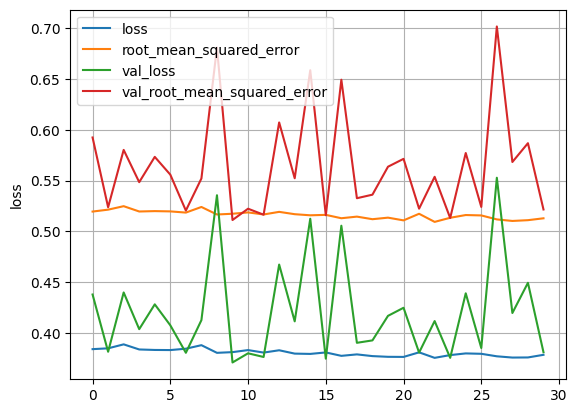

In [140]:
# 8-1. 모델 평가
import matplotlib.pyplot as plt
import seaborn as sb
his_data=pd.DataFrame(run_history.history)
plt.figure()
for col in his_data.columns:
  sb.lineplot(x=his_data.index,y=his_data[col],label=col)
plt.grid()
plt.show()
plt.close()

확실히 시계열 데이터를 일반적으로만 계산시키니 위와같은 학습결과가 나온다